# Notebook for ActorCritic RL model for OpenAI LunarLander

In [39]:
#Python3
import numpy as np
import gym
import Box2D
import torch
import torchvision
import argparse
import random
import matplotlib.pyplot as plt
from time import time
from torch.autograd import Variable
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Give args

In [40]:
class args_parse():
    def __init__(self):
        self.num_episodes = 1000
        self.max_frames = 100
        self.gamma = 0.99
        self.lr = 0.99
        

In [41]:
args = args_parse()

Now we define the Actor Critic Class

In [42]:
class ActorCritic(nn.Module):
    """ Creates a functionally merged Actor and Critic network models, both
        built of fully connected layers
        -- input:
            - env_space: Size of input vector from environment(int)
            - action_space: Size of output vector for action softmax onehot
            - n_hidden (optional): Number nodes in hidden layers (int)
            - mode: Training or testing/demoing?
        -- output:
            - action: The softmax onehot encoded action vector
            - expected_value: The expected value from the state-action pair
    """
    def __init__(self, env_space, action_space, n_hidden=6, lr=args.lr):
        super(ActorCritic, self).__init__()
        self.action_space = action_space
        self.env_space = env_space
        self.n_hidden = n_hidden
        self.saved_actions = []
        self.saved_rewards = []
        
        #define combined Network
        self.l1 = nn.Linear(env_space, n_hidden*2)
        self.l2 = nn.Linear(n_hidden*2, n_hidden)
        self.action_head = nn.Linear(n_hidden, action_space)
        self.value_head = nn.Linear(n_hidden, 1)
        
    def forward(self, env):
        x = F.relu(self.l1(env))
        x = F.relu(self.l2(x))
        action_scores = self.action_head(x)
        state_value = self.value_head(x)
        return F.softmax(action_scores), state_value
    
    def select_action(self, env, train=False):
        action_scores, state_value = self.forward(env)
        m = Categorical(action_scores)
        action = m.sample()
        if train:
            self.saved_actions.append((m.log_prob(action), state_value))
        return action.data.numpy()[0]

In [43]:
def train(actor_critic):
    """ Trains a policy to take an action giving an environment observation,
        with the goal of maximizing the rewards from each trial
        -- input:
            - actor_critic: A combined net of class ActorCritic
        -- output:
            - cum_rewards: A list of length args.num_episodes where each 
                           element is the cumulative reward of an episode,
                           the plot should describe the training success
            - actor_critic: A combined network trained over args.num_episodes
                            (not returned)
    """
    optimizer = optim.Adam(actor_critic.parameters(), lr=args.lr)
    cum_rewards = [0 for x in range(0, args.num_episodes)]
    for episode in range(0, args.num_episodes):
        collect_samples(actor_critic)
        saved_actions = actor_critic.saved_actions
        saved_rewards = actor_critic.saved_rewards
        R=0
        policy_losses = []
        value_losses = []
        rewards = []
        for reward in saved_rewards[::-1]:
            R = reward + (args.gamma * R)
            rewards.insert(0,R)
        rewards = torch.Tensor(rewards)
        #rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
        #for (log_prob, value), r in zip(saved_actions, rewards):
        random_sampling = random.sample(list(zip(saved_actions, rewards)), len(saved_actions)//2)
        for (log_prob, value), r in random_sampling:
            advantage = r - value.data[0]
            policy_losses.append(-log_prob * advantage)
            value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]))))
        optimizer.zero_grad()
        #stacks one tensor on another, sums for cumulative grad for each loss
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()
        optimizer.step()
        del actor_critic.saved_actions[:]
        del actor_critic.saved_rewards[:]
    return cum_rewards
        
        

In [44]:
def collect_samples(actor_critic):
    """ Collects samples from an environment episode either until terminal
        state or until max number of frames reached
        -- input:
            - actor_critic: A combined net of class ActorCritic
        -- output:
            - actor_critic: Fills actor_critic.saved_actions with 
                            (log_prob(action), state_value) pairs, and 
                            fills the actor_critic.saved_rewards with 
                            rewards from environment given the action 
                            taken (not returned)
    """
    env = gym.make('LunarLander-v2')
    state = Variable(torch.FloatTensor(env.reset()))
    isterminal = False
    frame = 0
    while (isterminal != True) and (frame < args.max_frames):
        soft_act, _ = actor_critic(state)
        action_taken = actor_critic.select_action(state, train=True)
        print(action_taken)
        next_state, reward, isterminal, _ = env.step(action_taken)
        next_state = Variable(torch.FloatTensor(next_state))
        actor_critic.saved_rewards.append(reward)
        state = next_state
        frame += 1

In [45]:
def demo(actor_critic, render=True):
    env = gym.make('LunarLander-v2')
    state = env.reset()
    isterminal = False
    frame = 0
    while (isterminal != True) and (frame < args.max_frames):
        if render:
            env.render()
        state = Variable(torch.Tensor(state))
        action = actor_critic.select_action(state)
        state, reward, isterminal, _ = env.step(action)
        frame += 1
    env.close()

In [46]:
actor_critic = ActorCritic(env_space=8, action_space=4)

In [47]:
cum_rewards = (train(actor_critic))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
2
0
3
3
0
1
2
2
3
3
0
0
0
3
3
0
3
2
2
0
0
0
0
3
3
2
3
1
3
1
1
2
0
0
3
3
3
0
0
0
3
2
3
3
3
3
3
0
2
3
3
2
3
2
1
1
0
3
1
3
0
1
3
2
2
3
1
1
3
2
0
0
2
0
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0
0
1
1
1
0
1
1
0
1
1
0
0
0
0
1
1
1
0
0
1
1
1
1
1
0
1
0
0
0
1
0
1
1
0
1
1
0
0
1
1
0
0
1
0
1
1
0
0
1
1
1
0
0
0
0
0
1
1
1
0
0
1
0
0
1
1
0
1
1
0
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


/Users/spencerlheureux/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Plea

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetec

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtyp

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please pro

KeyboardInterrupt: 

66.72441384505544


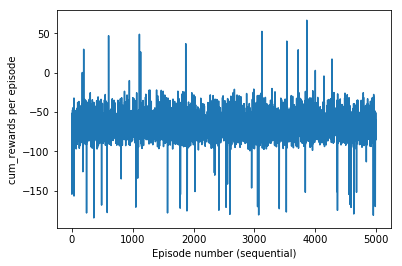

In [11]:
print(max(cum_rewards))
plt.plot(cum_rewards)
plt.ylabel('cum_rewards per episode')
plt.xlabel('Episode number (sequential)')
plt.show()

In [12]:
demo(actor_critic)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/spencerlheureux/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
